In [1]:
import base64
import numpy as np
# from pycocotools import _mask as coco_mask
import typing as t
import zlib
import torch
import shutil
import os
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Image as show_image
from torch.utils.data import DataLoader
from skimage.measure import regionprops_table, label, regionprops
from pycocotools import _mask as coco_mask
import gc
import warnings
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from PIL import Image
import torch.nn as nn
import random
import cv2
warnings.filterwarnings("ignore")

In [19]:
class model_config:
    current_fold = 0
    key = "BT" #"MoCoV2"
    pretrained_resnet = False
    seed = 42
    train_batch_size = 8
    valid_batch_size = 1
    epochs = 200  # ~15 minutes per epoch
    learning_rate = 0.0014 # 0.001 for bs=16
    scheduler = "CosineAnnealingLR"
    num_training_samples = 5499
    T_max = int(
        num_training_samples / train_batch_size * epochs)  # number of iterations for a full cycle, need to change for different # of iterations. (iteration = batch size)
    weight_decay = 1e-6  # explore different weight decay (Adam optimizer)
    n_accumulate = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    iters_to_accumulate = max(1, 32 // train_batch_size)  # for scaling accumulated gradients
    eta_min = 1e-5
    model_save_directory = os.path.join(os.getcwd(), "model",
                                        "seresnext_attention_dropout_dilation_v2_retry")

# sets the seed of the entire notebook so results are the same every time we run for reproducibility. no randomness, everything is controlled.
def set_seed(seed=42):
    np.random.seed(seed)  #numpy specific random
    random.seed(seed)  # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed)  # torch specific random
    torch.cuda.manual_seed(seed)  # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hases like dictionary

set_seed(model_config.seed)

In [58]:
class HubmapDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, transforms):
        self.transforms = transforms
        self.imgs = imgs
        self.name_indices = [os.path.splitext(os.path.basename(i))[0] for i in imgs]

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        name = self.name_indices[idx]
        img=tiff.imread(img_path)
        # array = tiff.imread(img_path)
        # img = Image.fromarray(array)
        img = self.transforms(image=img)
        img = img['image']
        return img, name

    def __len__(self):
        return len(self.imgs)

In [59]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
debug = True
model_path = r"C:\Users\Kevin\PycharmProjects\hubmap\unet++_resnet50\model\seresnext_attention_dropout_dilation_v3\best_epoch-00.pt"
base_dir = Path('/kaggle/input/hubmap-hacking-the-human-vasculature')
image_paths = r"\\fatherserverdw\Kevin\hubmap\train_overlap\images"
# test_paths = [os.path.join(image_paths,x) for x in os.listdir(image_paths) if x.endswith(".tif")][0:10] #load all train and debug or do just first hundreds
test_paths = [r"\\fatherserverdw\Kevin\hubmap\train_overlap\images\5631a47d5b0c.tif"]
test_paths

['\\\\fatherserverdw\\Kevin\\hubmap\\train_overlap\\images\\5631a47d5b0c.tif']

In [60]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [61]:
test_transforms = A.Compose([ToTensorV2()]) # Size C x H x W tensor with float dtype

dataset_test = HubmapDataset(test_paths, transforms = test_transforms)
test_dl = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [62]:
def build_model():
    model = smp.UnetPlusPlus(encoder_name="se_resnext101_32x4d", encoder_weights=None, encoder_depth = 5, decoder_channels = [512, 256, 128, 64, 32], activation='sigmoid',
                             in_channels=3, classes=1, decoder_attention_type="scse", decoder_use_batchnorm=True,
                             aux_params={"classes": 1, "pooling": "max", "dropout": 0.5})
    model.to(device)  # model to gpu
    return model

In [73]:
model = build_model()
id_list, heights, widths, prediction_strings = [],[],[],[]
with torch.no_grad():
    model.load_state_dict(torch.load(model_path))
    for img, idx in tqdm(test_dl):
        model.eval() #eval stage
        img = img.to(device,dtype= torch.float32)
        prediction, _  = model(img)
        prediction = torch.squeeze(prediction)
#         print("prob_prediction is {}".format(prob_prediction))
        print("max of prob prediction is {}".format(torch.max(prediction)))
        print("mean of prob prediction is {}".format(torch.mean(prediction)))
        print("min of prob prediction is: {}".format(torch.min(prediction)))
        binary_prediction = prediction > 0.000001
        binary_prediction

100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

max of prob prediction is 1.0
mean of prob prediction is 0.010033367201685905
min of prob prediction is: 0.0


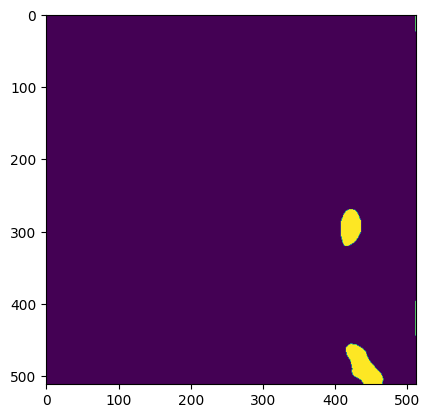

In [74]:
binary_prediction_cpu = binary_prediction.cpu().numpy()
plt.imshow(binary_prediction_cpu)

In [77]:
### Irrelevant code to see how much bv is in the image:

In [75]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def calculate_total_relative_area(file_path):
    # Get all .tif file paths in the specified directory
    file_paths = [os.path.join(file_path, file) for file in os.listdir(file_path) if file.endswith('.tif')]

    total_area = 0

    for file_path in tqdm(file_paths):
        # Load the image using PIL
        image = Image.open(file_path)

        # Convert the image to a numpy array
        binary_mask = np.array(image)

        # Calculate the total number of labels (ones) in the binary mask
        num_labels = np.sum(binary_mask == 1)

        # Calculate the total relative area of the labels
        relative_area = num_labels / (512 * 512)

        # Accumulate the relative area across all images
        total_area += relative_area

    return total_area


In [76]:
calculate_total_relative_area(r"\\fatherserverdw\Kevin\hubmap\train_overlap\masks\blood_vessel")

100%|██████████| 6874/6874 [01:21<00:00, 84.14it/s] 


351.7162437438965

In [78]:
351.7/6874

0.051163805644457376

In [ ]:
import pandas as pd
def remove_rows_by_names_from_excel(excel_file_path, names_to_remove):
    try:
        # Read the Excel file into a DataFrame
        df = pd.read_excel(excel_file_path)

        # Remove rows that contain any of the names from the list
        df = df[~df['Column_Name'].str.contains('|'.join(names_to_remove))]

        # Save the updated DataFrame back to the Excel file
        df.to_excel(excel_file_path, index=False)
        print("Rows with specified names have been removed successfully.")
    except Exception as e:
        print(f"Error occurred while processing the Excel file: {e}")

In [ ]:
# Replace 'your_excel_file_path' with the path to your Excel file
excel_file_path = r"\\fatherserverdw\Kevin\hubmap\unet++_v2\train_fold1.xlsx"
names_list = ['458a92eda7b4_bot_right.tif',
 '214866956ea3_top_right.tif',
 '4c1361e4c2d8_bot_left.tif',
 '578c8b32057e_top_left.tif',
 'cbc4758c8c53_bot_right.tif',
 '936f9bfb3966_top_right.tif',
 'e5ac1caaadd8_bot_left.tif',
 '27ac6c438f3b_top_left.tif',
 '97f404585e68_bot_right.tif',
 'aef16812206a_top_right.tif',
 '8cb7d2ef7d2c_bot_left.tif',
 '7aeb05949f93_top_left.tif',
 '7aeb05949f93_bot_right.tif',
 '76a3142ef6ee_top_right.tif',
 '3fc432760114_bot_left.tif',
 'cfcbc3b1aa48_top_left.tif',
 '2b1cf5bbc9ea_bot_right.tif',
 '9d3653466f61_top_right.tif',
 '5e8476b465f9_bot_left.tif',
 'e8758c97b189_top_left.tif',
 '89184912fef8_bot_right.tif',
 '4dae128831ab_top_right.tif',
 'dcd2a14a9980_bot_left.tif',
 '93c7422d2878_top_left.tif',
 '3dee55fb6fcc_bot_right.tif',
 '22db9740ba20_top_right.tif',
 '590f64bf82a6_bot_left.tif',
 'b3ee5e7bcf74_top_left.tif'] # Replace this list with the one returned by the previous function
remove_rows_by_names_from_excel(excel_file_path, names_list)
